# Tasks: Set 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, spectrogram
from function import Nyquist_frequency_of_quadratic_chirp,generate_quadratic_chirp,innerprodpsd,statgaussnoisegen
from scipy.signal import firwin2, fftconvolve

In [2]:
snr = 10 

In [3]:
nSamples = 2048
fs       = 1024
timeVec  = np.arange(nSamples) / fs 

In [4]:
A = 1.0 # Amplitude
a1, a2, a3 = 10, 3, 3 # Coefficients for the quadratic chirp
sigVec = generate_quadratic_chirp(timeVec, A, a1, a2, a3)

In [5]:
def noisePSD(f):
    return ((f>=100) & (f<=300)) * (f-100)*(300-f)/10000 + 1

In [6]:
dataLen    = nSamples / fs
kNyq       = nSamples//2 + 1
posFreq    = np.arange(kNyq) * (1/dataLen)   
psdPosFreq = noisePSD(posFreq)              

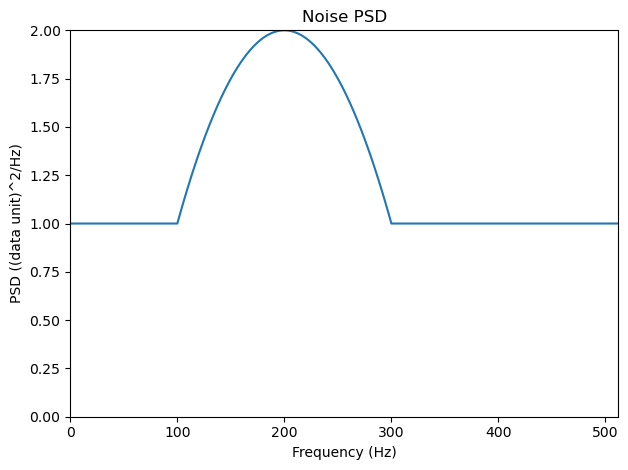

In [7]:
plt.figure()
plt.plot(posFreq, psdPosFreq)
plt.axis([0, posFreq[-1], 0, np.max(psdPosFreq)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((data unit)^2/Hz)')
plt.title('Noise PSD')
plt.tight_layout()
plt.show()

In [9]:

norm_sig_sq = innerprodpsd(sigVec, sigVec, fs, psdPosFreq)

sigVec = snr * sigVec / np.sqrt(norm_sig_sq)


In [11]:
nH0Data = 1000
llrH0 = np.zeros(nH0Data)

for lp in range(nH0Data):
    noiseVec = statgaussnoisegen(
        nSamples,
        np.column_stack((posFreq, psdPosFreq)),  
        fltrOrdr=100,                           
        sampFreq=fs
    )
    llrH0[lp] = innerprodpsd(noiseVec, sigVec, fs, psdPosFreq)

In [12]:
nH1Data = 1000
llrH1 = np.zeros(nH1Data)

for lp in range(nH1Data):
    noiseVec = statgaussnoisegen(
        nSamples,
        np.column_stack((posFreq, psdPosFreq)),
        fltrOrdr=100,
        sampFreq=fs
    )
    dataVec = noiseVec + sigVec
    llrH1[lp] = innerprodpsd(dataVec, sigVec, fs, psdPosFreq)

In [13]:
estSNR = (llrH1.mean() - llrH0.mean()) / llrH0.std()
print(f'Estimated SNR = {estSNR:.2f}')

Estimated SNR = 9.90


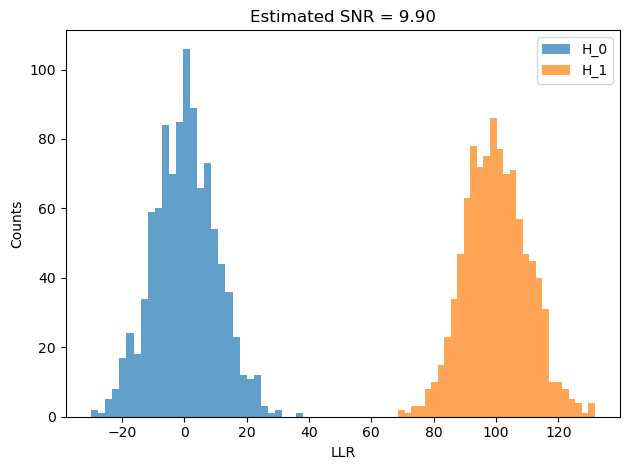

In [14]:
plt.figure()
plt.hist(llrH0, bins=30, alpha=0.7, label='H_0')
plt.hist(llrH1, bins=30, alpha=0.7, label='H_1')
plt.xlabel('LLR')
plt.ylabel('Counts')
plt.legend()
plt.title(f'Estimated SNR = {estSNR:.2f}')
plt.tight_layout()
plt.show()

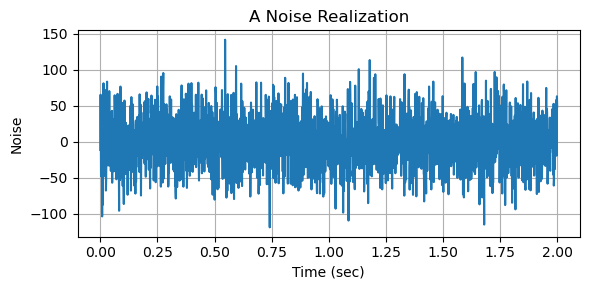

In [15]:
plt.figure(figsize=(6,3))
plt.plot(timeVec, noiseVec, color='tab:blue')
plt.xlabel('Time (sec)')
plt.ylabel('Noise')
plt.title('A Noise Realization')
plt.grid(True)
plt.tight_layout()
plt.show()

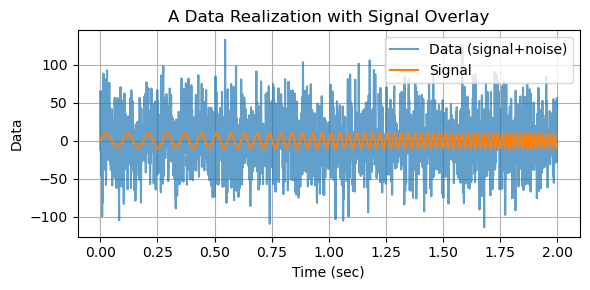

In [16]:
plt.figure(figsize=(6,3))
plt.plot(timeVec, dataVec, label='Data (signal+noise)', color='tab:blue', alpha=0.7)
plt.plot(timeVec, sigVec,  label='Signal',           color='tab:orange', linewidth=1.5)
plt.xlabel('Time (sec)')
plt.ylabel('Data')
plt.title('A Data Realization with Signal Overlay')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

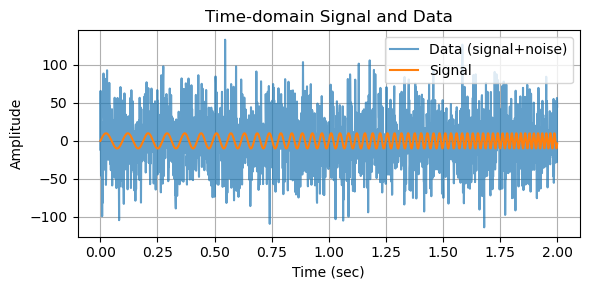

In [17]:
noise = noiseVec 
data  = dataVec
plt.figure(figsize=(6,3))
plt.plot(timeVec, data, label='Data (signal+noise)', alpha=0.7)
plt.plot(timeVec, sigVec, label='Signal', linewidth=1.5)
plt.xlabel('Time (sec)'); plt.ylabel('Amplitude')
plt.title('Time-domain Signal and Data') 
plt.legend(loc='upper right'); plt.grid(True); plt.tight_layout()
plt.show()

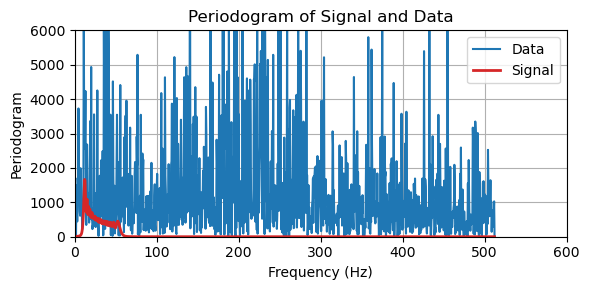

In [18]:
freqs = posFreq
P_sig  = (np.abs(np.fft.rfft(sigVec))**2) / nSamples
P_data = (np.abs(np.fft.rfft(data))**2)   / nSamples
plt.figure(figsize=(6,3))
plt.plot(freqs, P_data, label='Data', color='tab:blue')
plt.plot(freqs, P_sig,  label='Signal', color='tab:red', linewidth=2)
plt.xlim(0, 600); plt.ylim(0, 6000)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Periodogram')
plt.title('Periodogram of Signal and Data')
plt.legend(loc='upper right'); plt.grid(True); plt.tight_layout()
plt.show()

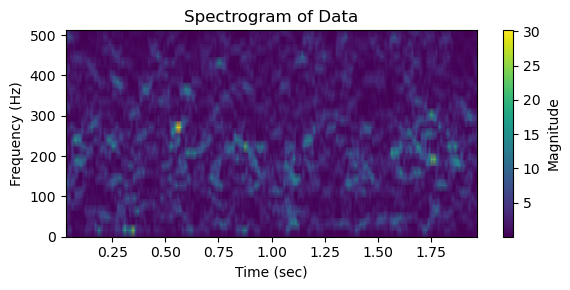

In [20]:
f_spec, t_spec, Sxx = spectrogram(dataVec, fs, nperseg=64, noverlap=60)
plt.figure(figsize=(6, 3))
plt.pcolormesh(t_spec, f_spec, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of Data')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

# Tasks: Set 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, spectrogram
from function import Nyquist_frequency_of_quadratic_chirp,generate_quadratic_chirp,innerprodpsd,statgaussnoisegen
from scipy.signal import firwin2, fftconvolve
from scipy.interpolate import interp1d
from numpy.fft import rfft, irfft

In [2]:
snr_target = 20.0
nSamples = 2048
fs = 1024.0
time = np.arange(nSamples)/fs
rng = np.random.default_rng(12345)

In [3]:
A = 1.0 # Amplitude
a1, a2, a3 = 10, 3, 3 # Coefficients for the quadratic chirp
sigVec = generate_quadratic_chirp(time, A, a1, a2, a3)

In [4]:
f_irreg = np.array([
    1,1.1,1.21,1.33,1.46,1.61,1.77,1.95,2.14,2.36,2.59,2.85,3.14,
    3.45,3.8,4.18,4.59,5.05,5.56,6.12,6.73,7.4,8.14,8.95,9.85,
    10.83,11.92,13.11,14.42,15.86,17.45,19.19,21.11,23.23,25.55,
    28.1,30.91,34,37.4,41.14,45.26,49.79,54.76,60.24,66.26,72.89,
    80.18,88.2,97.02,106.72,117.39,129.13,142.04,156.25,171.87,
    189.06,207.97,228.76,251.64,276.8,304.48,334.93,368.42,405.27,
    445.79,490.37,539.41,593.35,652.68,717.95,789.75,868.72,955.59,
    1051.15,1156.27,1271.9,1399.08,1538.99,1692.89,1862.18,2048.4,
    2253.24,2478.56,2726.42,2999.06,3298.97,3628.87,3991.75,4390.93,
    4830.02,5313.02,5844.32,6428.76,7071.63,7778.8,8556.68,9412.34
])
psd_irreg = np.array([
    1.57837977,0.415636725,0.10945014,0.029126516,0.007893535,
    0.002007471,0.000532826,0.000137318,3.74e-05,9.49e-06,
    2.58e-06,6.77e-07,1.74e-07,4.66e-08,1.21e-08,3.17e-09,
    8.57e-10,2.25e-10,5.85e-11,1.53e-11,4.04e-12,1.07e-12,
    2.81e-13,7.46e-14,1.95e-14,5.17e-15,1.35e-15,3.56e-16,
    9.39e-17,2.48e-17,6.50e-18,1.72e-18,4.52e-19,1.18e-19,
    3.12e-20,8.26e-21,2.21e-21,6.60e-22,3.11e-22,2.28e-22,
    1.86e-22,1.54e-22,1.27e-22,1.06e-22,8.77e-23,7.30e-23,
    6.10e-23,5.13e-23,4.37e-23,3.77e-23,3.32e-23,3.02e-23,
    2.83e-23,2.75e-23,2.75e-23,2.84e-23,2.98e-23,3.17e-23,
    3.41e-23,3.69e-23,4.01e-23,4.37e-23,4.77e-23,5.22e-23,
    5.71e-23,6.26e-23,6.87e-23,7.54e-23,8.27e-23,9.09e-23,
    9.98e-23,1.10e-22,1.21e-22,1.32e-22,1.46e-22,1.60e-22,
    1.76e-22,1.94e-22,2.13e-22,2.34e-22,2.57e-22,2.83e-22,
    3.11e-22,3.43e-22,3.77e-22,4.14e-22,4.56e-22,5.01e-22,
    5.51e-22,6.07e-22,6.67e-22,7.34e-22,8.07e-22,8.88e-22,
    9.77e-22,1.07e-21,1.18e-21
])

kNyq = nSamples//2 + 1
posFreq = np.linspace(0, fs/2, kNyq)
psd_interp = interp1d(f_irreg, psd_irreg, kind='linear', bounds_error=False,
                      fill_value=(psd_irreg[0], psd_irreg[-1]))
psdPosFreq = psd_interp(posFreq)
psdPosFreq = np.maximum(psdPosFreq, 1e-300)

In [7]:
norm_before = innerprodpsd(sigVec, sigVec, fs, psdPosFreq)
sig = snr_target * sigVec / np.sqrt(norm_before)

In [8]:
# freq-domain noise generator
def noise_from_psd_freqdomain(psdPos, N, fs, rng):
    delta_f = fs / N
    re = rng.normal(size=len(psdPos))
    im = rng.normal(size=len(psdPos))
    coeff = (re + 1j*im) * np.sqrt(psdPos * delta_f / 2.0)
    coeff[0] = coeff[0].real
    if N % 2 == 0:
        coeff[-1] = coeff[-1].real
    return irfft(coeff, n=N)

In [9]:
# calibration: empirical var(innerprod(noise,sig))
Mcal = 300
vals = np.zeros(Mcal)
for i in range(Mcal):
    n0 = noise_from_psd_freqdomain(psdPosFreq, nSamples, fs, rng)
    vals[i] = innerprodpsd(n0, sig, fs, psdPosFreq)
emp_var = np.var(vals, ddof=1)
desired_var = innerprodpsd(sig, sig, fs, psdPosFreq)   # should be snr_target^2
scale_noise = np.sqrt(desired_var / emp_var)

In [10]:
# Monte Carlo LLR
nTrials = 500
llrH0 = np.zeros(nTrials); llrH1 = np.zeros(nTrials)
for i in range(nTrials):
    n0 = noise_from_psd_freqdomain(psdPosFreq, nSamples, fs, rng) * scale_noise
    llrH0[i] = innerprodpsd(n0, sig, fs, psdPosFreq)
    n1 = noise_from_psd_freqdomain(psdPosFreq, nSamples, fs, rng) * scale_noise
    llrH1[i] = innerprodpsd(n1 + sig, sig, fs, psdPosFreq)

estSNR = (np.mean(llrH1) - np.mean(llrH0)) / np.std(llrH0, ddof=1)
print("Estimated SNR =", estSNR)

Estimated SNR = 19.5975348885988


# Task:Set 3

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, spectrogram
from lab_1_part_1 import Nyquist_frequency_of_quadratic_chirp,generate_quadratic_chirp,glrtqcsig,innerprodpsd
from scipy.signal import firwin2, fftconvolve

In [41]:
# Test
fs = 1024
nSamples = 2048
t = np.arange(nSamples) / fs
psdPosFreq = np.ones(nSamples//2+1)

a1, a2, a3 = 10, 3, 3
snr_test = 5
s_clean = generate_quadratic_chirp(t, 1.0, a1, a2, a3)
norm_sq = innerprodpsd(s_clean, s_clean, fs, psdPosFreq)
s_clean = snr_test * s_clean / np.sqrt(norm_sq)
noise = np.random.randn(nSamples)
y = s_clean + noise

glrt_val = glrtqcsig(y, t, fs, psdPosFreq, [a1, a2, a3])
glrt_val


24.440052029770815

# Task：Set4

In [34]:
import numpy as np
from scipy.signal import firwin2, fftconvolve
from numpy.fft import fft
from pathlib import Path
from function import Nyquist_frequency_of_quadratic_chirp,generate_quadratic_chirp,innerprodpsd,statgaussnoisegen

In [28]:
nSamples = 2048
sampFreq = 1024.0
timeVec = np.arange(nSamples) / sampFreq
a1, a2, a3 = 10.0, 3.0, 3.0

In [29]:
data_files = ["D:\Jupyter\LZU\data1.txt", "D:\Jupyter\LZU\data2.txt", "D:\Jupyter\LZU\data3.txt"]
data_realizations = [np.loadtxt(f).flatten()[:nSamples] for f in data_files]

In [30]:
# 噪声 PSD
def noisePSD(f):
    return ((f >= 100.0) & (f <= 300.0)) * (f - 100.0) * (300.0 - f) / 10000.0 + 1.0

# 正频率 PSD
kNyq = nSamples // 2 + 1
posFreq = np.linspace(0.0, sampFreq / 2.0, kNyq)
psdPosFreq = noisePSD(posFreq)

In [31]:
# 双边 PSD
def full_psd(psd_pos):
    if nSamples % 2 == 0:
        return np.concatenate([psd_pos, psd_pos[1:-1][::-1]])
    else:
        return np.concatenate([psd_pos, psd_pos[1:][::-1]])
psd_full = full_psd(psdPosFreq)

In [35]:
sig_template = generate_quadratic_chirp(timeVec, 1.0, a1, a2, a3)
norm_sig_sq = innerprodpsd(sig_template, sig_template, sampFreq, psdPosFreq)
template_unit = sig_template / np.sqrt(norm_sig_sq)

In [36]:
glrt_obs = []
for idx, data in enumerate(data_realizations, 1):
    llr = innerprodpsd(data, template_unit, sampFreq, psdPosFreq)
    glrt_val = llr**2
    glrt_obs.append(glrt_val)
    print(f"Data #{idx}: GLRT = {glrt_val:.6f}")

Data #1: GLRT = 10.606878
Data #2: GLRT = 71.419198
Data #3: GLRT = 2.781155


In [37]:
# Monte Carlo 下的 p-value 估计
M = 500
tol = 1e-3
prev_p = np.zeros(3)
psd_col = np.column_stack((posFreq, psdPosFreq))

while True:
    glrtH0 = np.zeros(M)
    for i in range(M):
        noise = statgaussnoisegen(nSamples, psd_col, 100, sampFreq)
        llr = innerprodpsd(noise, template_unit, sampFreq, psdPosFreq)
        glrtH0[i] = llr**2

    p_vals = [(np.sum(glrtH0 >= g) + 1) / (M + 1) for g in glrt_obs]
    print(f"M={M}, p-values: {p_vals}")

    if np.all(np.abs(np.array(p_vals) - prev_p) < tol):
        break
    prev_p = np.array(p_vals)
    M *= 2

M=500, p-values: [np.float64(0.001996007984031936), np.float64(0.001996007984031936), np.float64(0.11377245508982035)]
M=1000, p-values: [np.float64(0.001998001998001998), np.float64(0.000999000999000999), np.float64(0.08791208791208792)]
M=2000, p-values: [np.float64(0.0014992503748125937), np.float64(0.0004997501249375312), np.float64(0.08295852073963018)]
M=4000, p-values: [np.float64(0.0012496875781054736), np.float64(0.00024993751562109475), np.float64(0.08897775556110972)]
M=8000, p-values: [np.float64(0.0013748281464816899), np.float64(0.00012498437695288088), np.float64(0.09648793900762405)]
M=16000, p-values: [np.float64(0.001187425785888382), np.float64(6.249609399412537e-05), np.float64(0.09455659021311168)]
M=32000, p-values: [np.float64(0.0012187119152526483), np.float64(3.1249023468016625e-05), np.float64(0.09771569638448799)]
M=64000, p-values: [np.float64(0.0010468586428337057), np.float64(1.5624755863189637e-05), np.float64(0.09521726223027766)]
M=128000, p-values: [np